<a href="https://colab.research.google.com/github/Tommy-Adisa/Sentiment-Analysis-For-Customer-Review-using-RoBBETa-Transformer-Model/blob/main/sentiment_analysis_for_customer_review_using_robbeta_transformer_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import nltk
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the NLTK data directory
nltk_data_path = "/content/drive/MyDrive/nltk_data"
nltk.data.path.append(nltk_data_path)




Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/colab_packages')

import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
import contractions  # Import contractions library

from spellchecker import SpellChecker #Import spellcheck library. this handles errors in spellings
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

from torch.utils.data import DataLoader

In [ ]:
#This is to import data from the dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/ADVANCE PRACTICE/GROUP_4_SENTIMENT_ANALYSIS/Projects/Projects/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#This is to check the first 7 head of the data
df.head(7)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."
5,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Bought a lot of batteries for Christmas and th...,... batteries for Christmas and the AmazonBasi...,ByPainter Marlow,"https://www.barcodable.com/upc/841710106442,ht..."
6,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,ive not 

In [ ]:
#This is to output the dimension of a dataFrame
print(df.shape)

(28332, 24)


In [ ]:
#this is to get the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14  reviews.didPurchase  9 non-null      object 
 15  reviews.doRecommend  16086 non-null 

#Handling Missing Values


In [ ]:
# Drop missing values in 'reviews.text' column
df.dropna(subset=['reviews.text'], inplace=True)

# Convert all reviews to string format
df['reviews.text'] = df['reviews.text'].astype(str)

# Check for missing values again
print(df.isnull().sum())

id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              0
reviews.username           5
sourceURLs                 0
dtype: int64


#We want to reduce some futures that are not needed for the scope of this project and also reduce data from 28000+ to 2000 because of limitation we have due to GPU.

In [ ]:
df.drop(columns=["id", "dateUpdated", "asins","brand","categories", "imageURLs", "keys", "manufacturer", "manufacturerNumber","reviews.didPurchase", "reviews.doRecommend", "reviews.id", "reviews.numHelpful", "reviews.username"], inplace=True)

print(df.isnull().sum())

dateAdded             0
name                  0
primaryCategories     0
reviews.date          0
reviews.dateSeen      0
reviews.rating        0
reviews.sourceURLs    0
reviews.text          0
reviews.title         0
sourceURLs            0
dtype: int64


# using statify to reduce the data so that the peculiarity of the dataset will not be lost in the process of reduction


In [ ]:
from sklearn.model_selection import train_test_split

# Here we use stratify because the data is imbalance. Review.rating was used to reduce the dataset from 28000+ to 2000
df_sampled, _ = train_test_split(df, train_size=2000, stratify=df["reviews.rating"], random_state=42)

df_sampled.to_csv("reduced_dataset.csv", index=False)
print("Stratified dataset reduction complete!")

#This is to output the dimension of a dataFrame
print(df_sampled.shape)

#This is to check the first 7 head of the data
df_sampled.head(7)

Stratified dataset reduction complete!
(2000, 10)


,dateAdded,name,primaryCategories,reviews.date,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,sourceURLs
24027,2017-01-11T06:58:33Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Electronics,2016-08-24T00:00:00.000Z,"2017-04-26T00:00:00Z,2017-06-04T00:00:00Z,2017...",5,http://reviews.bestbuy.com/3545/5026000/review...,I own 3 Kindles. They are my favorite hand hel...,Perfect for a child,http://reviews.bestbuy.com/3545/5026000/review...
21346,2017-03-06T14:59:25Z,"Fire Tablet with Alexa, 7 Display, 16 GB, Mage...",Electronics,2017-04-04T00:00:00.000Z,"2017-04-30T00:00:00Z,2017-06-07T00:00:00Z",4,http://reviews.bestbuy.com/3545/5025900/review...,Great tablet with a lot of features. Great pri...,Great tablet,http://reviews.bestbuy.com/3545/5025900/review...
25008,2017-03-03T16:56:06Z,"Kindle E-reader - White, 6 Glare-Free Touchscr...","Office Supplies,Electronics",2017-02-23T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",5,http://reviews.bestbuy.com/3545/5435001/review...,I use this every day on my commute. Great batt...,Great for reading on the go,https://reviews.bestbuy.com/3545/5435001/revie...
6571,2015-10-30T08:59:32Z,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,1,https://www.amazon.com/product-reviews/B00QWO9...,Not suitable for toys. Drained within just a c...,Not suitable for toys. Drained within just a c...,"https://www.barcodable.com/upc/841710106442,ht..."
1634,2015-10-30T08:59:32Z,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,2015-11-17T00:00:00.000Z,2017-08-28T00:00:00Z,5,https://www.amazon.com/product-reviews/B00QWO9...,"Excellent price, good long-lasting batteries. ...",Five Stars,"https://www.barcodable.com/upc/841710106442,ht..."
27157,2017-03-06T14:59:43Z,"Fire HD 8 Tablet with Alexa, 8 HD Display, 16 ...",Electronics,2017-03-31T00:00:00.000Z,"2017-04-30T00:00:00Z,2017-06-07T00:00:00Z",4,http://reviews.bestbuy.com/3545/5620410/review...,Great tablet for the price. My father in law l...,Great tablet,http://reviews.bestbuy.com/3545/5620410/review...
10181,2015-12-03T01:23:41Z,AmazonBasics AA Performance Alkaline Batteries...,Health & Beauty,2016-04-05T00:00:00.000Z,2017-06-28T00:00:00Z,4,https://www.amazon.com/product-reviews/B00QWO9...,good,Four Stars,"https://www.barcodable.com/upc/841710106411,ht..."


#### loading pre-trained sentiment models from Hugging Face


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
import torch
from transformers import pipeline

from huggingface_hub import login




login("hf login tokin here")

# Define a mapping for RoBERTa labels
label_map = {
    "LABEL_2": "Positive",
    "LABEL_1": "Neutral",
    "LABEL_0": "Negative"
}



# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Load RoBERTa sentiment analysis model on GPU if available
roberta_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", device=device)
# Load RoBERTa sentiment analysis model
#roberta_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Function to analyze sentiment using RoBERTa
def analyze_sentiment(text):
    result = roberta_pipeline(text[:512])[0]  # Truncate if too long
    return label_map[result["label"]]  # Convert LABEL_X to meaningful label


# Apply sentiment analysis to your dataset
df_sampled["roberta_sentiment"] = df_sampled["reviews.text"].apply(analyze_sentiment)

# Show some results
df_sampled[["reviews.text", "roberta_sentiment"]].head()
df_sampled.head(5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,dateAdded,name,primaryCategories,reviews.date,reviews.dateSeen,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,sourceURLs,roberta_sentiment
24027,2017-01-11T06:58:33Z,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Electronics,2016-08-24T00:00:00.000Z,"2017-04-26T00:00:00Z,2017-06-04T00:00:00Z,2017...",5,http://reviews.bestbuy.com/3545/5026000/review...,I own 3 Kindles. They are my favorite hand hel...,Perfect for a child,http://reviews.bestbuy.com/3545/5026000/review...,Positive
21346,2017-03-06T14:59:25Z,"Fire Tablet with Alexa, 7 Display, 16 GB, Mage...",Electronics,2017-04-04T00:00:00.000Z,"2017-04-30T00:00:00Z,2017-06-07T00:00:00Z",4,http://reviews.bestbuy.com/3545/5025900/review...,Great tablet with a lot of features. Great pri...,Great tablet,http://reviews.bestbuy.com/3545/5025900/review...,Positive
25008,2017-03-03T16:56:06Z,"Kindle E-reader - White, 6 Glare-Free Touchscr...","Office Supplies,Electronics",2017-02-23T00:00:00.000Z,"2018-05-27T00:00:00Z,2017-07-07T00:00:00Z,2017...",5,http://reviews.bestbuy.com/3545/5435001/review...,I use this every day on my commute. Great batt...,Great for reading on the go,https://reviews.bestbuy.com/3545/5435001/revie...,Positive
6571,2015-10-30T08:59:32Z,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,2016-03-28T00:00:00.000Z,2017-08-28T00:00:00Z,1,https://www.amazon.com/product-reviews/B00QWO9...,Not suitable for toys. Drained within just a c...,Not suitable for toys. Drained within just a c...,"https://www.barcodable.com/upc/841710106442,ht...",Negative
1634,2015-10-30T08:59:32Z,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,2015-11-17T00:00:00.000Z,2017-08-28T00:00:00Z,5,https://www.amazon.com/product-reviews/B00QWO9...,"Excellent price, good long-lasting batteries. ...",Five Stars,"https://www.barcodable.com/upc/841710106442,ht...",Positive


<ipython-input-12-9a8309337080>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


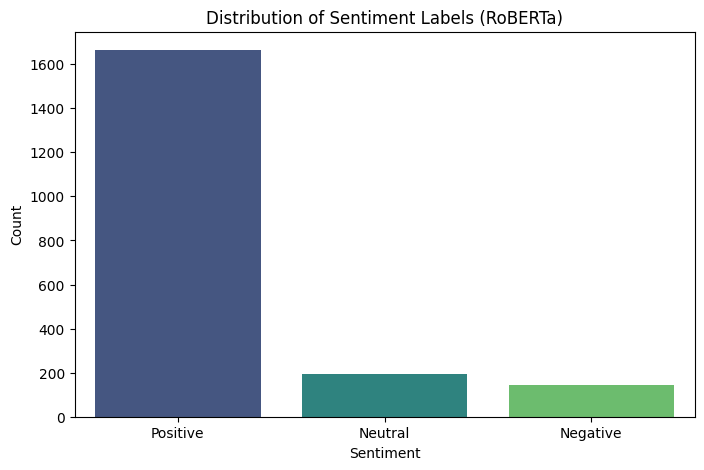

In [ ]:

# Count the occurrences of each sentiment label
sentiment_counts = df_sampled["roberta_sentiment"].value_counts()

# Plot the counts
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Distribution of Sentiment Labels (RoBERTa)")
plt.show()


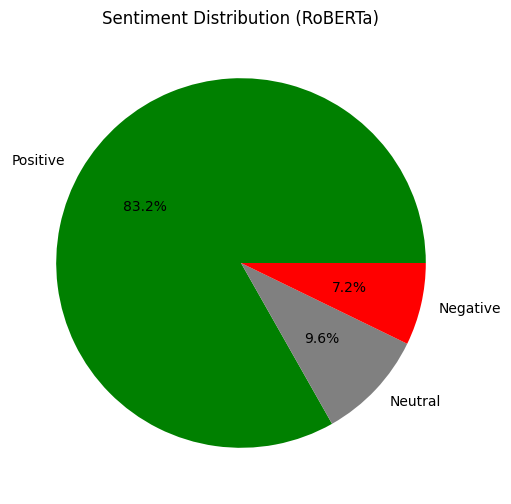

In [ ]:
# Plot a pie chart
plt.figure(figsize=(6,6))
sentiment_counts.plot(kind="pie", autopct="%1.1f%%", colors=["green", "gray", "red"])
plt.ylabel("")  # Hide y-label
plt.title("Sentiment Distribution (RoBERTa)")
plt.show()


In [ ]:
#print(df_sampled.head())  # See if data exists before filtering
print(df_sampled["roberta_sentiment"].value_counts())  # Check class distribution


roberta_sentiment
Positive    1664
Neutral      192
Negative     144
Name: count, dtype: int64


#fine tune the dataset

In [ ]:
from datasets import Dataset, ClassLabel
from sklearn.model_selection import train_test_split

# Define class mapping
label_mapping = {"Positive": 2, "Neutral": 1, "Negative": 0}
df_sampled["label"] = df_sampled["roberta_sentiment"].map(label_mapping)

# Drop NaNs if any
df_sampled = df_sampled.dropna(subset=["reviews.text", "label"])

# Split into train and test sets (80-20 split)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sampled["reviews.text"].tolist(), df_sampled["label"].tolist(), test_size=0.2, stratify=df_sampled["label"]
)

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
test_dataset = Dataset.from_dict({"text": test_texts, "label": test_labels})

# Define ClassLabel feature (ensures the labels are recognized properly)
class_label_feature = ClassLabel(num_classes=3, names=["Negative", "Neutral", "Positive"])
train_dataset = train_dataset.cast_column("label", class_label_feature)
test_dataset = test_dataset.cast_column("label", class_label_feature)

print(train_dataset, test_dataset)

print(train_dataset[5])  # Print first sample
print(test_dataset[5])   # Print first sample



Casting the dataset:   0%|          | 0/1600 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label'],
    num_rows: 1600
}) Dataset({
    features: ['text', 'label'],
    num_rows: 400
})
{'text': "Love these batteries! They last a long time and the price is very reasonable. I think they're just as good as, if not better than Duracell or Energizer brand. I prefer these over the name brand batteries. A+ product!", 'label': 2}
{'text': "Not bad can with stand my almost 2 yr old daughters wrath of every day wear and tear. So it's a win for me....", 'label': 2}


In [ ]:
from collections import Counter

train_labels = [example['label'] for example in train_dataset]
test_labels = [example['label'] for example in test_dataset]

print("Train Label Distribution:", Counter(train_labels))
print("Test Label Distribution:", Counter(test_labels))


Train Label Distribution: Counter({2: 1331, 1: 154, 0: 115})
Test Label Distribution: Counter({2: 333, 1: 38, 0: 29})


#TOKENIZATION This is to tokenize the text

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Tokenization function
#def tokenize_function(example):
#    return tokenizer(example["text"], padding="max_length", truncation=True)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)


# Apply tokenization to both train and test sets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Remove unprocessed text column (we don’t need it anymore after tokenization)
train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])

# Set format for PyTorch
train_dataset.set_format("torch")
test_dataset.set_format("torch")


Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

# Here, we load RoBERTa for Fine tuning with a classification head.
#Also specify batch size, learning rate, and training duration.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments

# Load pre-trained RoBERTa model (3 output labels)
model = AutoModelForSequenceClassification.from_pretrained(
    "cardiffnlp/twitter-roberta-base-sentiment", num_labels=3
)


training_args = TrainingArguments(
    output_dir="./roberta_sentiment_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,  # Adjust epochs as needed
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=500,
    load_best_model_at_end=True
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Handling Inbalance data Using CrossEntropyLoss
#We will apply Class Weights for Imbalanced Data. This is because we have more positive values compared to negative and neutral values

In [ ]:
import torch
import numpy as np
import torch.nn as nn
from transformers import Trainer

# Compute class weights (inverse frequency method)
class_counts = np.array(df_sampled["label"].value_counts().sort_index())
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda")  # Move to GPU if available

# Custom Trainer to apply weighted loss
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


#This is compare the label distribution before and after training.

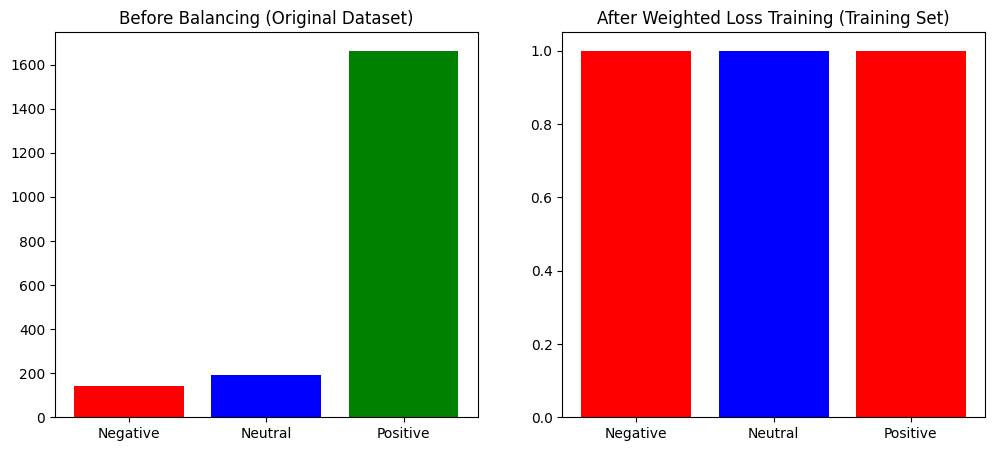

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Before balancing
original_counts = df_sampled["label"].value_counts().sort_index()

# After balancing - Approximate distribution by looking at the dataset labels again
train_labels = [example["label"] for example in train_dataset]
train_counts = Counter(train_labels)

# Plot distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before balancing
ax[0].bar(original_counts.index, original_counts.values, color=['red', 'blue', 'green'])
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(["Negative", "Neutral", "Positive"])
ax[0].set_title("Before Balancing (Original Dataset)")

# After balancing (weighted loss applied)
ax[1].bar(train_counts.keys(), train_counts.values(), color=['red', 'blue', 'green'])
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(["Negative", "Neutral", "Positive"])
ax[1].set_title("After Weighted Loss Training (Training Set)")

plt.show()


#TRAINING THE MODEL

In [ ]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

trainer.train()


<ipython-input-21-9d51b1561df3>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedLossTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adisaoluwatominiyi (adisaoluwatominiyi-teesside-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.455328
2,No log,1.023328
3,No log,0.868493


TrainOutput(global_step=300, training_loss=0.33441131591796874, metrics={'train_runtime': 567.2746, 'train_samples_per_second': 8.462, 'train_steps_per_second': 0.529, 'total_flos': 1262944405094400.0, 'train_loss': 0.33441131591796874, 'epoch': 3.0})

#This is to Evaluate the model

In [ ]:
# Evaluate the model on the test dataset
eval_results = trainer.evaluate()

# Print evaluation results
print(eval_results)


{'eval_loss': 0.4553278386592865, 'eval_runtime': 10.5041, 'eval_samples_per_second': 38.08, 'eval_steps_per_second': 2.38, 'epoch': 3.0}


#Here we extract predictions and compare them with actual labels.

In [ ]:
import torch
import numpy as np

# Get predictions
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)  # Convert logits to class labels

# Get actual labels
actual_labels = np.array(test_dataset["label"])


#Next is to Compute performance metrics. We will use accuracy, precision, recall, and F1-score to measure the model’s performance.

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# Compute accuracy
accuracy = accuracy_score(actual_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Generate a classification report
report = classification_report(actual_labels, predicted_labels, target_names=["Negative", "Neutral", "Positive"])
print(report)


Accuracy: 0.9500
              precision    recall  f1-score   support

    Negative       0.87      0.90      0.88        29
     Neutral       0.74      0.82      0.78        38
    Positive       0.98      0.97      0.98       333

    accuracy                           0.95       400
   macro avg       0.86      0.89      0.88       400
weighted avg       0.95      0.95      0.95       400



#Visualising Performance using confusion Matrix

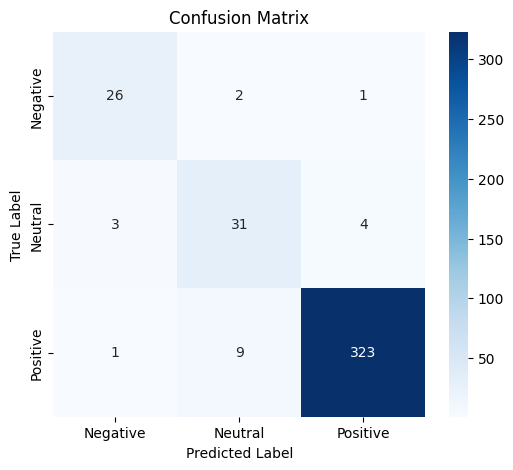

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Ensure predicted_labels is a list or convert it to one
predicted_labels = predicted_labels.tolist() if isinstance(predicted_labels, np.ndarray) else predicted_labels

# Extract misclassified reviews
misclassified = [test_texts[i] for i in range(len(actual_labels)) if actual_labels[i] != predicted_labels[i]]

# Print some misclassified examples
print("Sample misclassified reviews:")
for review in misclassified[:5]:
    print("-", review)


Sample misclassified reviews:
- But the youtube app has so many ads it has the kids on all kinds of stuff.
- Like it alot my child likes it so lets see how long itll last her
- I love my old kindle, but after a few years and drops the power button doesn't like to work a lot of the time. So took advantage Black Friday deal to replace the one that is going out.
- Not bad for generic
- It work


#Save the model in drive for reuse

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Define path in Google Drive
model_save_path = "/content/drive/MyDrive/saved_roberta_model"

# Save model and tokenizer
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"Model saved to {model_save_path} in Google Drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to /content/drive/MyDrive/saved_roberta_model in Google Drive
